# Localization



In this section, we look into getting a location for the tweets. This by 'geo', then 'place', then 'user_location'. For all, we try to get the location from the tweet text itself based on the TAGGS algorithm called geo-parsing  (https://link.springer.com/content/pdf/10.1007/s41651-017-0010-6.pdf) 

*Note that the “coordinates” attributes is formatted as [LONGITUDE, latitude], while the “geo” attribute is formatted as [latitude, LONGITUDE].

- Coordinates
- Place
- Geo-parsing
- User location


In [3]:
import pandas as pd
import numpy as np
import re
#import tweepy
import urllib.request

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import os
import string  
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image, ImageFont
import math
from fa2 import ForceAtlas2
import community
import datetime as dt
import warnings
from ast import literal_eval
import json

!pip install geograpy3
import geograpy

import folium
from folium.plugins import MarkerCluster


from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter



warnings.filterwarnings("ignore")

     |████████████████████████████████| 1.5MB 6.5MB/s 
     |████████████████████████████████| 215kB 17.7MB/s 
     |████████████████████████████████| 92kB 8.6MB/s 
     |████████████████████████████████| 10.1MB 16.2MB/s 
     |████████████████████████████████| 92kB 10.9MB/s 
     |████████████████████████████████| 7.4MB 50.5MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
     |████████████████████████████████| 235kB 54.1MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746863 sha256=a0a7b32b04fde65291550d921349685088bd0cbd99531374c982b8ec915fc034
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-cp37-none-any.whl size=3358 sha256=f82dc1718c2b5c8f13f1982e58579676a9df6f2969dcfb00b9f49b85b910aa85
  Stored in directory: /root/.cache/pip/wheels/de/03/ca/778e3a7a627e3d9

Labelled data from CrisisLexT6


https://crisislex.org/data-collections.html#CrisisLexT6


**Use cases from this source**

1. Alberta floods https://en.wikipedia.org/wiki/2013_Alberta_floods 
2. Queensland floods https://en.wikipedia.org/wiki/Cyclone_Oswald



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving eng_labelled_tweets_true.csv to eng_labelled_tweets_true.csv


In [5]:
import io
df = pd.read_csv(io.BytesIO(uploaded['eng_labelled_tweets_true.csv']))
df['tokens'] = [literal_eval(s) for s in df['tokens']]


for i in range(len(df)):
    try:
        df['geo'][i] = eval(df['geo'][i])
    except:
        df['geo'][i] = np.nan
    try:
        df['place'][i] = eval(df['place'][i])
    except:
        df['place'][i] = np.nan
   

## Location algorithm

First only take relevant tweets

In [6]:
df = df[df['relevant']==1]

### Geo (coordinate) attribute 


In [7]:
geo_df = df[~df['geo'].isna()].reset_index(drop=True)

#filter only relevant tweets
#geo_df = geo_df[geo_df['relevant']==1].reset_index(drop=True)
geo_df['coords'] = [geo_df['geo'][i]['coordinates'] for i in range(len(geo_df))]

print(len(geo_df))


594


In [8]:

madrid = [40.416775, -3.703790]

locationlist = list(geo_df['coords'])

map2 = folium.Map(location=madrid, tiles='CartoDB dark_matter', zoom_start=2)

marker_cluster = MarkerCluster().add_to(map2)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=geo_df['full_text'][point]).add_to(marker_cluster)
map2

Place attribute


In [9]:
#users with places
place_df = df[~df['place'].isna()].reset_index(drop=True)
#places and NOT geo

#geo_users = list(geo_df['user_id'])
#place_df = place_df[~place_df['user_id'].isin(geo_users)].reset_index(drop=True)
#print(len(place_df))

# add place_id
place_df['place_id'] =[place_df['place'][i]['id'] for i in range(len(place_df))]

# get dataframe with places metadata
places = [place_df['place'][i] for i in range(len(place_df))]
df_places= pd.DataFrame(places)

df_places= df_places.rename(columns={'id':'place_id'})
df_places = df_places.drop_duplicates(subset=['place_id'])


# merge to get all place details
place_df2 =pd.merge(place_df.drop(columns=['place']),df_places, on='place_id',how='inner')


In [10]:
polys = list(place_df2['bounding_box'])

for polygon in range(0, len(polys)): 
    folium.GeoJson(polys[polygon]).add_to(marker_cluster)
map2

In [11]:
userloc_df = df[~df['user_location'].isna()]

In [12]:
noloc_df = df[(df['user_location'].isna()) & (df['geo'].isna())  & (df['place'].isna()) ]
noloc_df2 = df[(df['geo'].isna()) & (df['place'].isna()) ]
len(noloc_df2)

6711

In [13]:
print(f'total : {len(df)}')
print(30*'_' + '\n')

print(f'geotagged : {len(geo_df)}')
print(f'places : {len(place_df2)}')
print(f'user location : {len(userloc_df)}')
print(f'no location : {len(noloc_df)}')

total : 7325
______________________________

geotagged : 594
places : 293
user location : 5981
no location : 1291


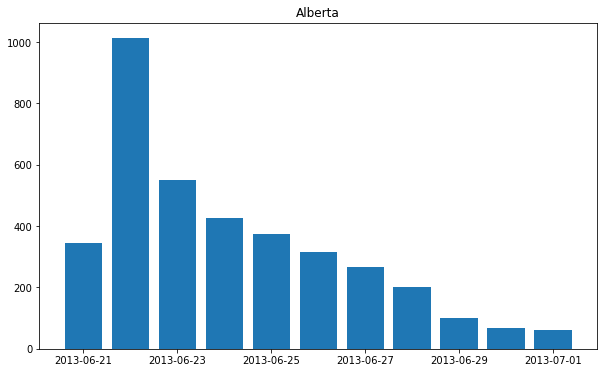

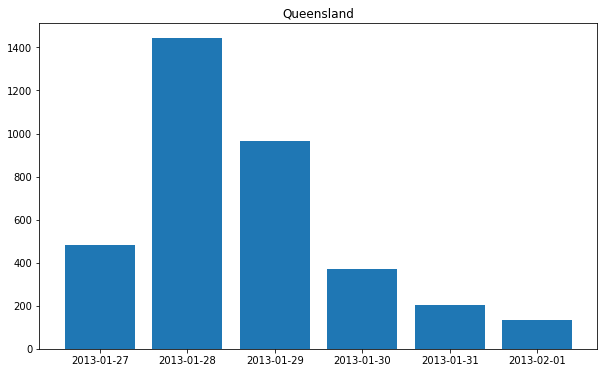

In [14]:
for area in ['Alberta','Queensland']:
    dfA = df[(df['area']==area) & (df['relevant']==1)].reset_index(drop=True)
    dfA['created_at'] = pd.to_datetime(dfA['created_at'])
    dfA['date'] = dfA['created_at'].dt.date
    dfdate =dfA.groupby('date').count().reset_index()
    plt.figure(figsize=(10,6))
    plt.bar(dfdate['date'],dfdate['tweet_id'])
    plt.title(area)
    plt.show()

### Geo-parsing 



In [16]:
df_new = df[(df['geo'].isna())  & (df['place'].isna())].reset_index(drop=True)
df_new.head()

,user_id,user_location,created_at,tweet_id,full_text,display_text_range,source,geo,coordinates,place,area,lang,relevant,tokens
0,26310303,Calgary,2013-06-24 00:02:07+00:00,348954149074911233,Anyone heard when power will be returning to C...,"[0, 70]","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,Alberta,en,1,"[anyone, heard, power, returning, cliff, bunga..."
1,521871577,"Rocky View County, Alberta",2013-06-24 02:32:09+00:00,348991908384739328,RT @aldjohnmar: This is what we're asking peop...,"[0, 138]","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,Alberta,en,1,"[rt, aldjohnmar, asking, people, indicate, sta..."
2,521871577,"Rocky View County, Alberta",2013-06-24 01:50:47+00:00,348981497895727105,RT @windspeakernews: Dear Calgary: If you find...,"[0, 140]","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,Alberta,en,1,"[rt, windspeakernews, dear, calgary, find, hom..."
3,521871577,"Rocky View County, Alberta",2013-06-24 15:04:42+00:00,349181291830321152,RT @CanadaBridges: Bridges ppl on route 2 #Mor...,"[0, 144]","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,Alberta,en,1,"[rt, canadabridges, bridge, ppl, route, morley..."
4,521871577,"Rocky View County, Alberta",2013-06-27 18:42:46+00:00,350323337064497154,RT @AFN_Updates: #AFN National Chief @shawnatl...,"[0, 136]","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,Alberta,en,1,"[rt, afnupdates, afn, national, chief, shawnat..."


1) toponym recognition

https://github.com/somnathrakshit/geograpy3 

colnames = ['geonameid','name', 'asciiname','alternatenames','latitude' ,'longitude' ,'feature class','feature code' ,'country code','cc2' ,'admin1 code' ,'admin2 code' ,'admin3 code','admin4 code','population' ,'elevation','dem','timezone' ,'modification date']

geonames1=pd.read_csv('../geonames/cities500.txt',header=None,sep="\t")
geonames=pd.DataFrame(geonames1.values, columns = colnames)
geonames['name_lower'] = geonames['asciiname'].str.lower()

In [23]:
import nltk
nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [27]:
df_new['geoparsing_country'] = ''
df_new['geoparsing_region'] = ''
df_new['geoparsing_city'] = ''
df_new['geoparsing_other'] = ''

for i in range(20):
    places = geograpy.get_place_context(text = df_new['full_text'][i])  
    df_new['geoparsing_country'][i] = places.countries
    df_new['geoparsing_region'][i] = places.regions
    df_new['geoparsing_city'][i] = places.cities
    df_new['geoparsing_other'][i] = places.other



In [31]:
geolocator.geocode('Alberta') 

Location(Alberta, Canada, (55.001251, -115.002136, 0.0))

In [33]:
list(df_new[:20]['geoparsing_city'])

[[],
 [],
 [],
 [],
 [],
 ['Alberta', 'High River'],
 [],
 [],
 [],
 ['Alberta'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['Broadview'],
 ['Calgary'],
 [],
 []]

In [ ]:
df_new

In [ ]:
# initialize geolocator
geolocator = Nominatim(user_agent='my_app') 
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

location_df['coordinates'] = '' 
location_df['address'] = '' 
locations = list(location_df['location'])  
exceptions = [] 
for i,loc in enumerate(locations): 
  
    try: 
        location = geolocator.geocode(loc) 
        location_df['coordinates'].iloc[i] = (location.latitude,location.longitude)
        location_df['address'].iloc[i] = location.address
    except: 
        #print('Exception:', loc) 
        exceptions.append(loc)


,user_id,user_location,created_at,tweet_id,full_text,display_text_range,source,geo,coordinates,place,area,lang,relevant,tokens,geoparsing_country,geoparsing_region,geoparsing_city,geoparsing_other
0,26310303,Calgary,2013-06-24 00:02:07+00:00,348954149074911233,Anyone heard when power will be returning to C...,"[0, 70]","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,Alberta,en,1,"[anyone, heard, power, returning, cliff, bunga...",[],[],[],[Cliff Bungalow]
1,521871577,"Rocky View County, Alberta",2013-06-24 02:32:09+00:00,348991908384739328,RT @aldjohnmar: This is what we're asking peop...,"[0, 138]","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,Alberta,en,1,"[rt, aldjohnmar, asking, people, indicate, sta...",[],[],[],[]
2,521871577,"Rocky View County, Alberta",2013-06-24 01:50:47+00:00,348981497895727105,RT @windspeakernews: Dear Calgary: If you find...,"[0, 140]","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,Alberta,en,1,"[rt, windspeakernews, dear, calgary, find, hom...",[],[],[],[]
3,521871577,"Rocky View County, Alberta",2013-06-24 15:04:42+00:00,349181291830321152,RT @CanadaBridges: Bridges ppl on route 2 #Mor...,"[0, 144]","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,Alberta,en,1,"[rt, canadabridges, bridge, ppl, route, morley...",[],[],[],[]
4,521871577,"Rocky View County, Alberta",2013-06-27 18:42:46+00:00,350323337064497154,RT @AFN_Updates: #AFN National Chief @shawnatl...,"[0, 136]","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,Alberta,en,1,"[rt, afnupdates, afn, national, chief, shawnat...",[],[],[],"[AFN National, Siksika Chief]"
5,521871577,"Rocky View County, Alberta",2013-06-26 23:50:28+00:00,350038381876625408,Red-headed ‘angel’ swept away in High River fl...,"[0, 111]","<a href=""https://dev.twitter.com/docs/tfw"" rel...",NaN,NaN,NaN,Alberta,en,1,"[redheaded, ‘angel’, swept, away, high, river,...","[United States, Canada]",[],"[Alberta, High River]",[]
6,521871577,"Rocky View County, Alberta",2013-06-22 00:12:55+00:00,348232091193974786,RT @Metro_Nolais: A lot of the price gouging s...,"[0, 138]","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,Alberta,en,1,"[rt, metronolais, lot, price, gouging, far, ga...",[],[],[],[]
7,102181149,Calgary,2013-06-28 17:26:13+00:00,350666458931531777,If you own a restaurant in #VicParkYYC here is...,"[0, 133]","<a href=""http://www.hootsuite.com"" rel=""nofoll...",NaN,NaN,NaN,Alberta,en,1,"[restaurant, vicparkyyc, excellent, resource, ...",[],[],[],[VicParkYYC]
8,376577618,"Kananaskis, Alberta",2013-06-24 17:19:10+00:00,349215134956265472,RT @WeatherFarm: Order a Bad Scuba @nenshi Tsh...,"[0, 140]","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,Alberta,en,1,"[rt, weatherfarm, order, bad, scuba, nenshi, t...",[],[],[],"[Bad Scuba, Tshirt, Red Cross Alberta Flood Re..."
9,376577618,"Kananaskis, Alberta",2013-06-25 19:28:33+00:00,349610081589010434,RT @suzyburge: Alberta floods have permanently...,"[0, 136]","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,Alberta,en,1,"[rt, suzyburge, alberta, flood, permanently, a...",[United States],[],[Alberta],[Rocky Mountains]


*2) toponym resolution*

First city, then region, then country -- maybe other.